In [1]:
import torch
import os
from torch._C import device
from torch.utils.data import Dataset, DataLoader
from transformers import (
    GPT2Tokenizer,
    GPT2LMHeadModel,
    AdamW,
    get_linear_schedule_with_warmup,
)
import torch.nn.functional as F
from tqdm import tqdm, trange

# COMMENT GENERATION

Lets generate comments using our fine-tuned model.

In [ ]:
def generate(
    model,
    tokenizer,
    prompt,
    entry_count=10,
    entry_length=100,
    top_p=0.8,
    temperature=1.0,
):

    model.eval()

    generated_num = 0
    generated_list = []

    filter_value = -float("Inf")

    with torch.no_grad():

        for entry_idx in trange(entry_count):

            entry_finished = False

            generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)

            # Using top-p (nucleus sampling): https://github.com/huggingface/transformers/blob/master/examples/run_generation.py

            for i in range(entry_length):
                outputs = model(generated, labels=generated)
                loss, logits = outputs[:2]
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)

                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(
                    F.softmax(sorted_logits, dim=-1), dim=-1
                )

                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                    ..., :-1
                ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value

                next_token = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
                generated = torch.cat((generated, next_token), dim=1)

                if next_token in tokenizer.encode("<|EOS|>"):
                    entry_finished = True

                if entry_finished:

                    generated_num = generated_num + 1

                    output_list = list(generated.squeeze().numpy())
                    output_text = tokenizer.decode(output_list)

                    generated_list.append(output_text)
                    break

            if not entry_finished:
                output_list = list(generated.squeeze().numpy())
                output_text = f"{tokenizer.decode(output_list)}<|EOS|>"
                generated_list.append(output_text)

    return generated_list

In [7]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.load_state_dict(torch.load('../trained_models/medtext-final.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [8]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [ ]:
generated_comments = generate(
    model.to('cpu'),
    tokenizer,
    "<|BOS|>",
    entry_count=10
)

with open("results/generated_comments.txt", "a") as file:
    file.write("\n".join(generated_comments))

# TOOL TESTING

Now that we have a little batch of 100 comments, let's test the tools and see how they perform, and what information we can extract with their help, as well as any other drawbacks they might add to our workflow.

In [1]:
import spacy
import re

In [2]:
spacy.__version__

'3.0.6'

In [3]:
with open('../results/generated_comments.txt') as file:
    lines = file.readlines()
    synth_comments = [l.removeprefix('<|BOS|>').rstrip('<|EOS|>\n') for l in lines]

In [4]:
synth_comments[5:10]

['Effect of specific antineoplastic (PAN) injection on the metabolic effect of interleukin-4. Plasmid DNA damage is due to accelerated mutagenesis, so the effects of CRISPR-Cas9-based CRISPR-Cas9 have been studied in vivo. These results suggest that LGM (LB) injection of LGM into mice (F3-F7+) induced an enhanced B-cell mass in LGM-induced mice. These effects were',
 'AIMS immunohistochemical evaluation of the formation of Helicobacter pylori pylori, an obligate obligate monobacterium with numerous mutations of its intracellular phenotype, using direct thrombin-immunoblotting systems. The immunohistochemical screening results of approximately 10 cases of Helicobacter pylori pylori (3 micrograms/ml) of varying ages showed clear abnormalities in all 6 years (mean age, 8 years).',
 'Unexpected findings in the linkage of orthostatic disequilibrium (AUC) and dyskinesia in patients with recurrent orthostatic muscle disease. Eighty-seven cases of dyskinesia were reported in 27 patients with r

## MED 7 

In [5]:
med7 = spacy.load("en_core_med7_trf")

In [6]:
doc = med7('1 gram of Advil every week')

In [12]:
text_data = [(ent.text, ent.label_) for ent in doc.ents]


In [26]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

In [27]:
counter = Counter([t[1] for t in text_data])
df = pd.DataFrame(counter.items(), columns=["Tag", "Count"])

In [29]:
 seven_colours = [
        "#e6194B",
        "#3cb44b",
        "#ffe119",
        "#ffd8b1",
        "#f58231",
        "#f032e6",
        "#42d4f4",
        "#ff0000",
        "#ff8700",
        "#ffd300",
        "#deff0a",
        "#a1ff0a",
        "#0aff99",
        "#0aefff",
        "#147df5",
        "#580aff",
        "#be0aff",
    ]

<BarContainer object of 3 artists>

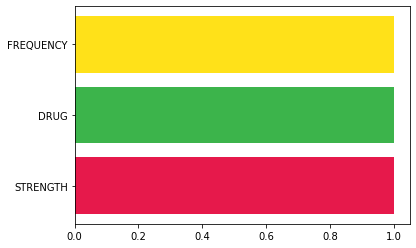

In [30]:
plt.figure()
plt.barh(df.Tag, df.Count, color=seven_colours)


In [13]:
[(ent.text) for ent in doc]

['1', 'gram', 'of', 'Advil', 'every', 'week']

In [30]:
doc = list(med7.pipe(synth_comments))

In [31]:
[[(ent.text, ent.label_) for ent in d.ents] for d in doc]


[[],
 [],
 [('gamma-cytosine', 'DRUG'), ('gamma-cytosine', 'DRUG')],
 [('cimetidine', 'DRUG')],
 [('creatine kinase', 'DRUG')],
 [],
 [],
 [],
 [],
 [('aspirin', 'DRUG'), ('aspirin', 'DRUG')],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [('metazolam', 'DRUG')],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [('anti-HIP', 'DRUG'),
  ('cyclohexylinositolide (CI and/or', 'DRUG'),
  ('digoxin', 'DRUG')],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [('tDCS', 'DRUG')],
 [],
 [('epinephrine', 'DRUG'), ('norepinephrine', 'DRUG'), ('melatonin', 'DRUG')],
 [],
 [('Caepristone', 'DRUG'), ('ceftriaxone', 'DRUG')],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [('oxytocin', 'DRUG'), ('oxytocin', 'DRUG'), ('oxytocin', 'DRUG')],
 [],
 [],
 [('oral', 'ROUTE'),
  ('gingival', 'DRUG'),
  ('injections', 'FORM'),
  ('oral', 'ROUTE'),
  ('gingival', 'DRUG')],
 [],
 [('anticonvulsant drugs', 'DRUG'),
  ('methylphenidate', 'DRUG'),
  ('30 mg', 'STRENGTH'),
  ('diazepam', 'DRUG'),
  ('piperazine', 'DRUG'),
  ('15-me